# 4. Model Training — Home Credit Default Risk

Bu notebook'ta preprocessing sonrası **model-ready** veri üzerinde tam modelleme pipeline'ı çalıştırılacaktır.

| Sıra | Adım | Açıklama |
|------|------|----------|
| 1 | **Baseline LightGBM** | Stratified K-Fold (5) + `scale_pos_weight` ile tuning'siz model |
| 2 | **Baseline XGBoost** | Aynı CV ve aynı imbalance ayarlarıyla karşılaştırma modeli |
| 3 | **Model Seçimi** | AUC / PR-AUC ortalamasına bakıp en iyi baseline'ı seçme |
| 4 | **Optuna Tuning** | Seçilen model için 50 trial hiperparametre araması |
| 5 | **Imbalance Check** | Gerekirse alternatif dengeleme stratejileri denemesi |
| 6 | **Final Model + CV** | En iyi ayarlarla tekrar CV + test tahminleri |
| 7 | **SHAP Analizi** | Global + bireysel açıklanabilirlik |

**Girdi:**
- `data/train_processed.parquet` — 307,511 x 169 (0 NaN, 0 kategorik)
- `data/test_processed.parquet` — 48,744 x 168

**Çıktı:**
- `models/lgbm_best_fold.pkl` — En iyi tek fold modeli
- `models/lgbm_all_folds.pkl` — Tüm fold modelleri (ensemble)
- `models/best_params.json` — En iyi hiperparametreler
- `data/oof_predictions.parquet` — OOF tahminleri
- `data/test_predictions.parquet` — Test tahminleri

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import pickle
import json

import lightgbm as lgb
import xgboost as xgb
import optuna
import shap

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_style('whitegrid')

RANDOM_STATE = 42
N_FOLDS = 5

os.makedirs('../notebooks/plots', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print('Setup complete.')

Setup complete.


---
## 1. Veri Yükleme ve Hazırlık

In [3]:
# Load processed data
df = pd.read_parquet('../data/train_processed.parquet')
test_df = pd.read_parquet('../data/test_processed.parquet')

print(f'Train: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'Test:  {test_df.shape[0]:,} rows x {test_df.shape[1]} columns')

# Split features and target
X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

test_ids = test_df['SK_ID_CURR']
X_test = test_df.drop(columns=['SK_ID_CURR'])

# Class balance
print(f'\nTarget Distribution:')
print(y.value_counts())
print(f'\nDefault Rate: {y.mean():.4f} ({y.mean()*100:.2f}%)')
print(f'Imbalance Ratio: 1:{(1-y.mean())/y.mean():.1f}')
print(f'\nFeatures: {X.shape[1]}')
print(f'Feature dtypes:\n{X.dtypes.value_counts()}')

Train: 307,511 rows x 169 columns
Test:  48,744 rows x 168 columns

Target Distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default Rate: 0.0807 (8.07%)
Imbalance Ratio: 1:11.4

Features: 167
Feature dtypes:
float32    75
int8       35
float64    33
int64      22
int16       2
Name: count, dtype: int64


In [4]:
# CV strategy
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# scale_pos_weight for imbalanced classes
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f'scale_pos_weight: {scale_pos_weight:.2f}')
print(f'CV Strategy: Stratified {N_FOLDS}-Fold (shuffle=True, seed={RANDOM_STATE})')

scale_pos_weight: 11.39
CV Strategy: Stratified 5-Fold (shuffle=True, seed=42)


---
## 2. Baseline LightGBM

İlk model: Varsayılan parametrelerle LightGBM.

- `scale_pos_weight` ile sınıf dengesizliği yönetimi
- `early_stopping(100)` ile overfitting kontrolü
- 5-Fold Stratified CV ile güvenilir performans ölçümü

> **Neden LightGBM?** Tabular, numeric-only ve dengesiz veride en stabil başlangıç noktası.
> NaN native desteği, hızlı eğitim, düşük bellek kullanımı.

In [5]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'n_estimators': 2000,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}

print('=' * 60)
print('BASELINE LightGBM  —  Stratified 5-Fold CV')
print('=' * 60)

lgb_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
lgb_models = []
lgb_oof_preds = np.zeros(len(X))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    lgb_oof_preds[val_idx] = y_pred

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    lgb_results['auc'].append(auc)
    lgb_results['pr_auc'].append(pr_auc)
    lgb_results['best_iter'].append(model.best_iteration_)
    lgb_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={model.best_iteration_}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(lgb_results["auc"]):.5f} +/- {np.std(lgb_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(lgb_results["pr_auc"]):.5f} +/- {np.std(lgb_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(lgb_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

lgb_oof_auc = roc_auc_score(y, lgb_oof_preds)
print(f'\n  OOF AUC:     {lgb_oof_auc:.5f}')

BASELINE LightGBM  —  Stratified 5-Fold CV
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's auc: 0.781784
  Fold 1: AUC=0.78178 | PR-AUC=0.27475 | best_iter=361
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	valid_0's auc: 0.789723
  Fold 2: AUC=0.78972 | PR-AUC=0.28526 | best_iter=370
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[364]	valid_0's auc: 0.782185
  Fold 3: AUC=0.78219 | PR-AUC=0.26733 | best_iter=364
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[385]	valid_0's auc: 0.786553
  Fold 4: AUC=0.78655 | PR-AUC=0.27776 | best_iter=385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[314]	valid_0's auc: 0.780863
  Fold 5: AUC=0.78086 | PR-AUC=0.27131 | best_iter=314

——————————————————————————————————————————————

---
## 3. Baseline XGBoost

Aynı CV yapısı ile XGBoost karşılaştırması.

- `scale_pos_weight` aynı değer
- `tree_method='hist'` ile hızlı eğitim
- `early_stopping_rounds=100`

> **Neden XGBoost da?** LightGBM'e alternatif güçlü bir ağaç modeliyle benchmark oluşturmak
> ve hangi algoritmanın sinyali daha iyi yakaladığını görmek için.

In [8]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 2000,
    'verbosity': 0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',
    'early_stopping_rounds': 100,
}

print('=' * 60)
print('BASELINE XGBoost  —  Stratified 5-Fold CV')
print('=' * 60)

xgb_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
xgb_models = []
xgb_oof_preds = np.zeros(len(X))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    xgb_oof_preds[val_idx] = y_pred

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    xgb_results['auc'].append(auc)
    xgb_results['pr_auc'].append(pr_auc)
    best_iter = getattr(model, 'best_iteration', getattr(model, 'best_iteration_', -1))
    xgb_results['best_iter'].append(best_iter)
    xgb_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={best_iter}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(xgb_results["auc"]):.5f} +/- {np.std(xgb_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(xgb_results["pr_auc"]):.5f} +/- {np.std(xgb_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(xgb_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

xgb_oof_auc = roc_auc_score(y, xgb_oof_preds)
print(f'\n  OOF AUC:     {xgb_oof_auc:.5f}')

BASELINE XGBoost  —  Stratified 5-Fold CV
  Fold 1: AUC=0.77904 | PR-AUC=0.27154 | best_iter=303
  Fold 2: AUC=0.78700 | PR-AUC=0.28016 | best_iter=342
  Fold 3: AUC=0.77996 | PR-AUC=0.26686 | best_iter=301
  Fold 4: AUC=0.78370 | PR-AUC=0.27795 | best_iter=302
  Fold 5: AUC=0.77748 | PR-AUC=0.26695 | best_iter=332

————————————————————————————————————————————————————————————
  Mean AUC:    0.78144 +/- 0.00345
  Mean PR-AUC: 0.27269 +/- 0.00551
  Mean Iters:  316
  Elapsed:     77.1s (1.3 min)

  OOF AUC:     0.78142


---
## 4. Model Seçimi — Baseline Karşılaştırması

AUC-ROC ve PR-AUC ortalamalarına bakarak hangi modelle tuning'e geçeceğimize karar veriyoruz.

> **Kural:** Kötü modeli tune etmek zaman kaybıdır — önce doğru atı seç.

BASELINE COMPARISON
   Model  AUC Mean  AUC Std  PR-AUC Mean  PR-AUC Std  OOF AUC  Avg Iters
LightGBM  0.784222 0.003378     0.275283    0.006083 0.784218      358.8
 XGBoost  0.781436 0.003453     0.272692    0.005507 0.781421      316.0


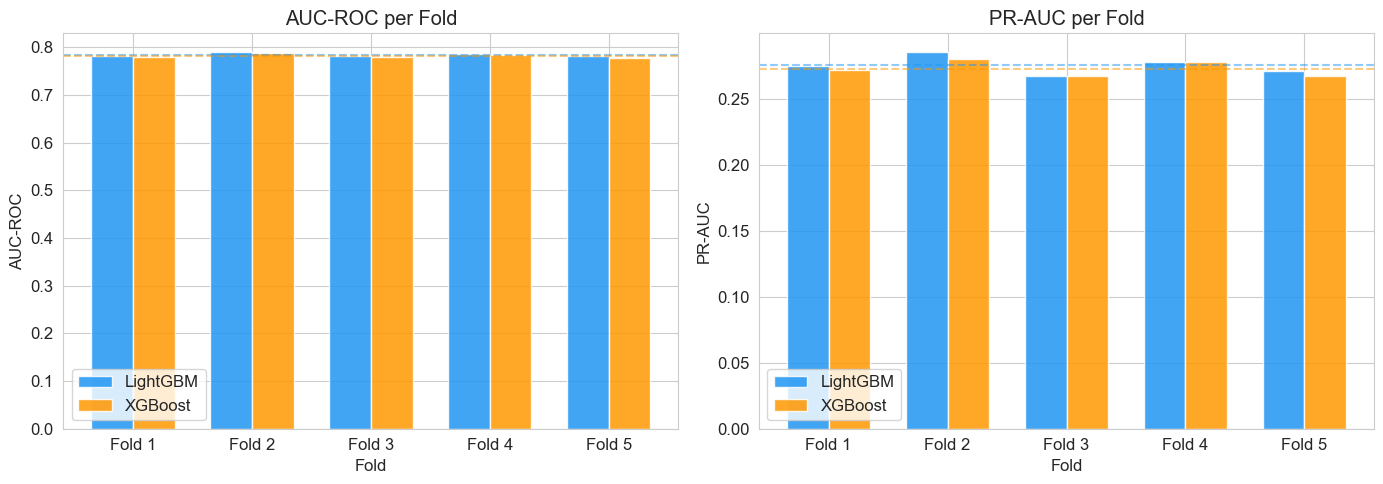


SECILEN MODEL: LightGBM (daha yuksek AUC Mean)


In [9]:
# Comparison table
comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'AUC Mean': [np.mean(lgb_results['auc']), np.mean(xgb_results['auc'])],
    'AUC Std': [np.std(lgb_results['auc']), np.std(xgb_results['auc'])],
    'PR-AUC Mean': [np.mean(lgb_results['pr_auc']), np.mean(xgb_results['pr_auc'])],
    'PR-AUC Std': [np.std(lgb_results['pr_auc']), np.std(xgb_results['pr_auc'])],
    'OOF AUC': [lgb_oof_auc, xgb_oof_auc],
    'Avg Iters': [np.mean(lgb_results['best_iter']), np.mean(xgb_results['best_iter'])],
})

print('BASELINE COMPARISON')
print('=' * 80)
print(comparison.to_string(index=False))

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(N_FOLDS)
width = 0.35

# AUC per fold
axes[0].bar(x - width/2, lgb_results['auc'], width, label='LightGBM', color='#2196F3', alpha=0.85)
axes[0].bar(x + width/2, xgb_results['auc'], width, label='XGBoost', color='#FF9800', alpha=0.85)
axes[0].axhline(y=np.mean(lgb_results['auc']), color='#2196F3', linestyle='--', alpha=0.5)
axes[0].axhline(y=np.mean(xgb_results['auc']), color='#FF9800', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('AUC-ROC')
axes[0].set_title('AUC-ROC per Fold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)])
axes[0].legend()

# PR-AUC per fold
axes[1].bar(x - width/2, lgb_results['pr_auc'], width, label='LightGBM', color='#2196F3', alpha=0.85)
axes[1].bar(x + width/2, xgb_results['pr_auc'], width, label='XGBoost', color='#FF9800', alpha=0.85)
axes[1].axhline(y=np.mean(lgb_results['pr_auc']), color='#2196F3', linestyle='--', alpha=0.5)
axes[1].axhline(y=np.mean(xgb_results['pr_auc']), color='#FF9800', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('PR-AUC')
axes[1].set_title('PR-AUC per Fold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(N_FOLDS)])
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebooks/plots/baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Model selection
best_baseline = 'LightGBM' if np.mean(lgb_results['auc']) >= np.mean(xgb_results['auc']) else 'XGBoost'
print(f'\nSECILEN MODEL: {best_baseline} (daha yuksek AUC Mean)')

---
## 5. Optuna ile Hyperparameter Tuning

Seçilen model (LightGBM) için **50 trial** hiperparametre optimizasyonu.

Aranacak parametreler:
- `learning_rate`: [0.01, 0.1] (log scale)
- `num_leaves`: [20, 150]
- `max_depth`: [3, 12]
- `min_child_samples`: [10, 100]
- `reg_alpha` / `reg_lambda`: [1e-8, 10] (log scale)
- `colsample_bytree` / `subsample`: [0.5, 1.0]
- `min_split_gain`: [0.0, 1.0]

> **Neden Optuna?** Bayesian optimizasyon ile grid/random search'ten cok daha verimli.
> TPE sampler ile 50 trial'da iyi bir noktaya ulasilir.

In [10]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'n_estimators': 2000,
        'verbose': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    }

    auc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(auc_scores)


print('=' * 60)
print('OPTUNA HYPERPARAMETER TUNING  —  50 Trials x 5-Fold CV')
print('=' * 60)

start = time.time()
study = optuna.create_study(direction='maximize', study_name='lgbm_tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)
elapsed = time.time() - start

print(f'\nBest Trial: #{study.best_trial.number}')
print(f'Best AUC:   {study.best_value:.5f}')
print(f'Elapsed:    {elapsed:.1f}s ({elapsed/60:.1f} min)')
print(f'\nBest Parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

OPTUNA HYPERPARAMETER TUNING  —  50 Trials x 5-Fold CV


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[848]	valid_0's auc: 0.782393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	valid_0's auc: 0.790089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[725]	valid_0's auc: 0.784114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[838]	valid_0's auc: 0.788544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[921]	valid_0's auc: 0.783283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[493]	valid_0's auc: 0.782257
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[299]	valid_0's auc: 0.788899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[388]	valid_0's auc: 0

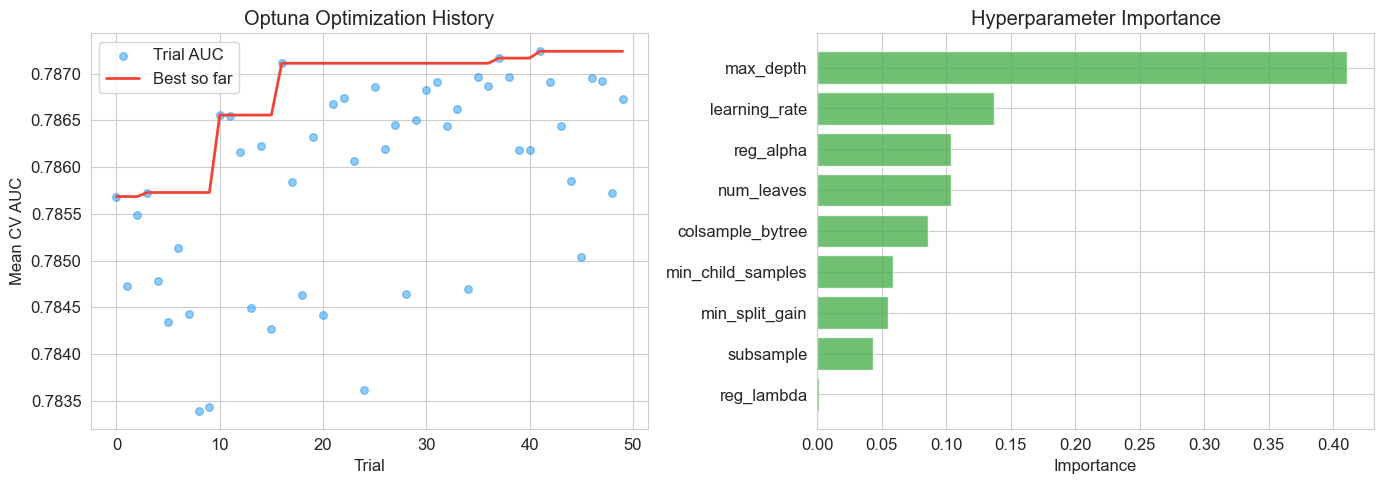


Baseline LightGBM AUC: 0.78422
Optuna Best AUC:       0.78724
Improvement:           30.2 bps


In [11]:
# Optuna visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials if t.value is not None]
trial_nums_valid = [t.number for t in trials if t.value is not None]
best_so_far = [max(trial_values[:i+1]) for i in range(len(trial_values))]

axes[0].scatter(trial_nums_valid, trial_values, alpha=0.5, color='#2196F3', s=30, label='Trial AUC')
axes[0].plot(trial_nums_valid, best_so_far, color='#F44336', linewidth=2, label='Best so far')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('Mean CV AUC')
axes[0].set_title('Optuna Optimization History')
axes[0].legend()

# Parameter importance
try:
    param_importance = optuna.importance.get_param_importances(study)
    params_sorted = dict(sorted(param_importance.items(), key=lambda x: x[1], reverse=True))
    axes[1].barh(
        list(params_sorted.keys())[::-1],
        list(params_sorted.values())[::-1],
        color='#4CAF50', alpha=0.8
    )
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Hyperparameter Importance')
except Exception as e:
    axes[1].text(0.5, 0.5, f'Could not compute\nimportance: {e}',
                 ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('../notebooks/plots/optuna_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

# Baseline vs Tuned comparison
print(f'\nBaseline LightGBM AUC: {np.mean(lgb_results["auc"]):.5f}')
print(f'Optuna Best AUC:       {study.best_value:.5f}')
print(f'Improvement:           {(study.best_value - np.mean(lgb_results["auc"]))*10000:.1f} bps')

---
## 5b. Optuna — PR-AUC Optimizasyonu

AUC-ROC genel ayırım gücünü ölçer, ama **imbalanced** problemlerde (%8 default)
**PR-AUC** (Average Precision) pozitif sınıfın yakalanma kalitesini daha iyi yansıtır.

İki study'yi karşılaştırıp **her iki metrikte de en iyi** parametreleri seçeceğiz.

> **Neden ikisi de?** AUC-optimized model genel sıralamada iyi olur,
> PR-AUC-optimized model default'ları yakalamada daha agresif olur.
> Hangisi daha iyi çalışırsa o seçilir.

In [12]:
def objective_prauc(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'n_estimators': 2000,
        'verbose': -1,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    }

    prauc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )

        y_pred = model.predict_proba(X_val)[:, 1]
        prauc_scores.append(average_precision_score(y_val, y_pred))

    return np.mean(prauc_scores)


print('=' * 60)
print('OPTUNA PR-AUC TUNING  —  50 Trials x 5-Fold CV')
print('=' * 60)

start = time.time()
study_prauc = optuna.create_study(direction='maximize', study_name='lgbm_prauc_tuning')
study_prauc.optimize(objective_prauc, n_trials=50, show_progress_bar=True)
elapsed = time.time() - start

print(f'\nBest Trial: #{study_prauc.best_trial.number}')
print(f'Best PR-AUC: {study_prauc.best_value:.5f}')
print(f'Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')
print(f'\nBest Parameters:')
for key, value in study_prauc.best_params.items():
    print(f'  {key}: {value}')

OPTUNA PR-AUC TUNING  —  50 Trials x 5-Fold CV


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1360]	valid_0's auc: 0.783708
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1119]	valid_0's auc: 0.791221
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1519]	valid_0's auc: 0.784738
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1337]	valid_0's auc: 0.789018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1513]	valid_0's auc: 0.784078
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's auc: 0.78297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.789125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's au

In [13]:
# ---- Compare AUC-optimized vs PR-AUC-optimized ----
# Quick CV evaluation of PR-AUC study params with BOTH metrics
prauc_eval_params = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 2000, 'verbose': -1,
    'random_state': RANDOM_STATE, 'n_jobs': -1,
}
prauc_eval_params.update(study_prauc.best_params)

prauc_study_auc = []
prauc_study_prauc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
    m = lgb.LGBMClassifier(**prauc_eval_params)
    m.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)],
          callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    yp = m.predict_proba(X_vl)[:, 1]
    prauc_study_auc.append(roc_auc_score(y_vl, yp))
    prauc_study_prauc.append(average_precision_score(y_vl, yp))

# Comparison table
print('=' * 70)
print('STUDY COMPARISON — AUC-optimized vs PR-AUC-optimized')
print('=' * 70)

comp_df = pd.DataFrame({
    'Study': ['AUC-optimized', 'PR-AUC-optimized'],
    'AUC Mean': [np.mean(lgb_results['auc']), np.mean(prauc_study_auc)],
    'AUC (Optuna best)': [study.best_value, np.mean(prauc_study_auc)],
    'PR-AUC Mean': [np.mean(lgb_results['pr_auc']), np.mean(prauc_study_prauc)],
})
print(comp_df.to_string(index=False))

# Select best study
auc_winner = 'AUC' if study.best_value >= np.mean(prauc_study_auc) else 'PR-AUC'
prauc_winner = 'AUC' if np.mean(lgb_results['pr_auc']) >= np.mean(prauc_study_prauc) else 'PR-AUC'

# Use PR-AUC-optimized if it wins PR-AUC AND doesn't lose much AUC
auc_diff = study.best_value - np.mean(prauc_study_auc)
prauc_diff = np.mean(prauc_study_prauc) - np.mean(lgb_results['pr_auc'])

if prauc_diff > 0 and auc_diff < 0.005:
    best_study = study_prauc
    best_study_name = 'PR-AUC-optimized'
    print(f'\nSECILEN: PR-AUC-optimized (PR-AUC +{prauc_diff*10000:.1f} bps, AUC fark {-auc_diff*10000:.1f} bps)')
else:
    best_study = study
    best_study_name = 'AUC-optimized'
    print(f'\nSECILEN: AUC-optimized (AUC daha yuksek veya PR-AUC farki yetersiz)')

print(f'\nFinal model {best_study_name} parametreleri ile egitilecek.')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1300]	valid_0's auc: 0.784424
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1148]	valid_0's auc: 0.791695
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1260]	valid_0's auc: 0.785342
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1262]	valid_0's auc: 0.789263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1226]	valid_0's auc: 0.784638
STUDY COMPARISON — AUC-optimized vs PR-AUC-optimized
           Study  AUC Mean  AUC (Optuna best)  PR-AUC Mean
   AUC-optimized  0.784222           0.787239     0.275283
PR-AUC-optimized  0.787072           0.787072     0.279690

SECILEN: PR-AUC-optimized (PR-AUC +44.1 bps, AUC fark -1.7 bps)

Final model PR-AUC-optimized parametreleri ile egitilecek.


---
## 6. Imbalance Kontrolu

Baseline'da `scale_pos_weight` kullandik. Recall yeterli mi kontrol ediyoruz.

> **Not:** SMOTE tree-based modellerde genellikle gereksizdir — `scale_pos_weight`
> ayni etkiyi gradient duzeyinde saglar. Sadece ihtiyac halinde denenecek.

In [14]:
# Recall check with different thresholds using LightGBM baseline OOF predictions
print('Threshold Analysis (LightGBM Baseline OOF Predictions)')
print('=' * 70)

thresholds = [0.50, 0.30, 0.20, 0.15, 0.10]
threshold_results = []

for thr in thresholds:
    y_pred_binary = (lgb_oof_preds >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_binary).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    threshold_results.append({
        'Threshold': thr,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    })

thr_df = pd.DataFrame(threshold_results)
print(thr_df.to_string(index=False, float_format='%.4f'))

print(f'\nYorum: Recall degerleri inceleniyor...')
print(f'scale_pos_weight={scale_pos_weight:.1f} ile calisiyoruz.')
print(f'Eger recall cok dusukse (threshold=0.5 ile <0.30), alternatif denenebilir.')
print(f'Tree-based modellerde scale_pos_weight genellikle yeterlidir.')

Threshold Analysis (LightGBM Baseline OOF Predictions)
 Threshold  Precision  Recall     F1    TP     FP   FN     TN
    0.5000     0.1880  0.6854 0.2951 17014  73476 7811 209210
    0.3000     0.1287  0.8812 0.2246 21877 148134 2948 134552
    0.2000     0.1062  0.9478 0.1909 23530 198108 1295  84578
    0.1500     0.0964  0.9729 0.1754 24152 226414  673  56272
    0.1000     0.0879  0.9913 0.1616 24608 255212  217  27474

Yorum: Recall degerleri inceleniyor...
scale_pos_weight=11.4 ile calisiyoruz.
Eger recall cok dusukse (threshold=0.5 ile <0.30), alternatif denenebilir.
Tree-based modellerde scale_pos_weight genellikle yeterlidir.


---
## 7. Final Model — Tuned LightGBM + Full CV

Optuna'nin buldugu en iyi parametrelerle tam 5-Fold CV calistiriyoruz.

Bu sefer ayrica:
- **OOF (Out-of-Fold) tahminleri** kaydedilecek (her satir bir kez val olarak gorulur)
- **Test tahminleri** 5 fold ortalamasiyla hesaplanacak (ensemble)
- **ROC ve PR-AUC egileri** cizilecek

In [ ]:
# Build final params from best study (AUC or PR-AUC optimized)
final_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 2000,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}
final_params.update(best_study.best_params)
print(f'Using: {best_study_name} parameters')

print('=' * 60)
print('FINAL MODEL  —  Tuned LightGBM  —  Stratified 5-Fold CV')
print('=' * 60)
print(f'\nParameters:')
for k, v in final_params.items():
    if k not in ['verbose', 'random_state', 'n_jobs']:
        val_str = f'{v:.6f}' if isinstance(v, float) else str(v)
        print(f'  {k}: {val_str}')

final_results = {'auc': [], 'pr_auc': [], 'best_iter': []}
final_models = []
final_oof_preds = np.zeros(len(X))
final_test_preds = np.zeros(len(X_test))

start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    final_oof_preds[val_idx] = y_pred

    # Test prediction — average across folds (ensemble)
    final_test_preds += model.predict_proba(X_test)[:, 1] / N_FOLDS

    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    final_results['auc'].append(auc)
    final_results['pr_auc'].append(pr_auc)
    final_results['best_iter'].append(model.best_iteration_)
    final_models.append(model)

    print(f'  Fold {fold+1}: AUC={auc:.5f} | PR-AUC={pr_auc:.5f} | best_iter={model.best_iteration_}')

elapsed = time.time() - start

print(f'\n{"—"*60}')
print(f'  Mean AUC:    {np.mean(final_results["auc"]):.5f} +/- {np.std(final_results["auc"]):.5f}')
print(f'  Mean PR-AUC: {np.mean(final_results["pr_auc"]):.5f} +/- {np.std(final_results["pr_auc"]):.5f}')
print(f'  Mean Iters:  {np.mean(final_results["best_iter"]):.0f}')
print(f'  Elapsed:     {elapsed:.1f}s ({elapsed/60:.1f} min)')

final_oof_auc = roc_auc_score(y, final_oof_preds)
final_oof_prauc = average_precision_score(y, final_oof_preds)
print(f'\n  OOF AUC:     {final_oof_auc:.5f}')
print(f'  OOF PR-AUC:  {final_oof_prauc:.5f}')

# Improvement summary
baseline_auc = np.mean(lgb_results['auc'])
tuned_auc = np.mean(final_results['auc'])
print(f'\n  Baseline AUC: {baseline_auc:.5f}')
print(f'  Tuned AUC:    {tuned_auc:.5f}')
print(f'  Improvement:  {(tuned_auc - baseline_auc)*10000:+.1f} bps')

In [ ]:
# ROC and Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y, final_oof_preds)
axes[0].plot(fpr, tpr, color='#2196F3', linewidth=2,
             label=f'Tuned LightGBM (AUC={final_oof_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve (OOF Predictions)')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# PR Curve
precision_arr, recall_arr, _ = precision_recall_curve(y, final_oof_preds)
axes[1].plot(recall_arr, precision_arr, color='#F44336', linewidth=2,
             label=f'Tuned LightGBM (PR-AUC={final_oof_prauc:.4f})')
axes[1].axhline(y=y.mean(), color='gray', linestyle='--', alpha=0.5,
                label=f'Baseline (prevalence={y.mean():.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (OOF Predictions)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Feature Importance (average split count across folds)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.mean([m.feature_importances_ for m in final_models], axis=0)
})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Top 30 features
top_n = 30
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(
    range(top_n),
    top_features['importance'].values[::-1],
    color='#4CAF50', alpha=0.8
)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Feature Importance (split count, avg across folds)')
ax.set_title(f'Top {top_n} Features — Tuned LightGBM')
plt.tight_layout()
plt.savefig('../notebooks/plots/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top 20
print('Top 20 Features:')
print(importance_df.head(20).to_string(index=False))

---
## 8. SHAP Analizi — Model Aciklanabilirligi

SHAP (SHapley Additive exPlanations) ile modelin karar mekanizmasini anliyoruz:

- **Global:** Tum veri setinde hangi feature'lar en etkili?
- **Bar Plot:** Ortalama mutlak SHAP degerleri (feature ranking)
- **Bireysel:** Tek bir musteri icin hangi faktorler riski artiriyor/azaltiyor?

> SHAP hesaplaması buyuk veride yavas oldugundan **5,000 orneklem** kullaniyoruz.

In [ ]:
# Use best fold model for SHAP
best_fold_idx = np.argmax(final_results['auc'])
shap_model = final_models[best_fold_idx]

# Subsample for speed
np.random.seed(RANDOM_STATE)
sample_size = 5000
sample_idx = np.random.choice(len(X), size=sample_size, replace=False)
X_sample = X.iloc[sample_idx]

print(f'Computing SHAP values ({sample_size:,} samples)...')
start = time.time()

explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_sample)

elapsed = time.time() - start
print(f'Done in {elapsed:.1f}s')

# For binary classification, shap_values may be list [class_0, class_1] or single array
if isinstance(shap_values, list):
    shap_vals = shap_values[1]  # positive class (default)
    expected_value = explainer.expected_value[1]
    print(f'SHAP output: list of 2 arrays (binary), using class 1')
else:
    shap_vals = shap_values
    expected_value = explainer.expected_value
    print(f'SHAP output: single array')

print(f'SHAP values shape: {shap_vals.shape}')
print(f'Expected value (base): {expected_value:.4f}')

In [ ]:
# Global SHAP Summary Plot (beeswarm)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals, X_sample, max_display=30, show=False)
plt.title('SHAP Summary Plot — Top 30 Features', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# SHAP Bar Plot (mean |SHAP|)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals, X_sample, plot_type='bar', max_display=30, show=False)
plt.title('Mean |SHAP| — Feature Importance Ranking', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

# SHAP vs LightGBM feature importance comparison
shap_importance = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': np.abs(shap_vals).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print('\nTop 15 Features by SHAP:')
print(shap_importance.head(15).to_string(index=False))

In [ ]:
# Individual SHAP Explanations
# Find high-risk and low-risk examples from our sample
sample_preds = final_oof_preds[sample_idx]
high_risk_local = np.argmax(sample_preds)
low_risk_local = np.argmin(sample_preds)

print('HIGH-RISK Customer:')
print(f'  Sample index: {high_risk_local}')
print(f'  Predicted probability: {sample_preds[high_risk_local]:.4f}')
print(f'  Actual TARGET: {y.iloc[sample_idx[high_risk_local]]}')

print(f'\nLOW-RISK Customer:')
print(f'  Sample index: {low_risk_local}')
print(f'  Predicted probability: {sample_preds[low_risk_local]:.4f}')
print(f'  Actual TARGET: {y.iloc[sample_idx[low_risk_local]]}')

In [ ]:
# High-risk waterfall
shap_exp_high = shap.Explanation(
    values=shap_vals[high_risk_local],
    base_values=expected_value,
    data=X_sample.iloc[high_risk_local].values,
    feature_names=X_sample.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_exp_high, max_display=15, show=False)
plt.title('SHAP Waterfall — High-Risk Customer', fontsize=13, pad=15)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Low-risk waterfall
shap_exp_low = shap.Explanation(
    values=shap_vals[low_risk_local],
    base_values=expected_value,
    data=X_sample.iloc[low_risk_local].values,
    feature_names=X_sample.columns.tolist()
)

plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_exp_low, max_display=15, show=False)
plt.title('SHAP Waterfall — Low-Risk Customer', fontsize=13, pad=15)
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_low_risk.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 9. Model Kaydetme ve Test Tahminleri

In [ ]:
# Save models
best_fold_idx = np.argmax(final_results['auc'])

with open('../models/lgbm_best_fold.pkl', 'wb') as f:
    pickle.dump(final_models[best_fold_idx], f)

with open('../models/lgbm_all_folds.pkl', 'wb') as f:
    pickle.dump(final_models, f)

# Save OOF predictions
oof_df = pd.DataFrame({
    'SK_ID_CURR': df['SK_ID_CURR'],
    'TARGET': y,
    'PREDICTED_PROBA': final_oof_preds
})
oof_df.to_parquet('../data/oof_predictions.parquet', index=False)

# Save test predictions (5-fold ensemble average)
test_pred_df = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'PREDICTED_PROBA': final_test_preds
})
test_pred_df.to_parquet('../data/test_predictions.parquet', index=False)

# Save best parameters
params_export = final_params.copy()
params_export['best_cv_auc_mean'] = float(np.mean(final_results['auc']))
params_export['best_cv_auc_std'] = float(np.std(final_results['auc']))
params_export['best_cv_prauc_mean'] = float(np.mean(final_results['pr_auc']))
params_export['oof_auc'] = float(final_oof_auc)
params_export['n_folds'] = N_FOLDS
params_export['n_optuna_trials'] = len(study.trials) + len(study_prauc.trials)
params_export['selected_study'] = best_study_name

with open('../models/best_params.json', 'w') as f:
    json.dump(params_export, f, indent=2, default=str)

# Save SHAP values
np.save('../models/shap_values.npy', shap_vals)
X_sample.to_parquet('../models/shap_sample.parquet', index=False)

print('All artifacts saved:')
print(f'  models/lgbm_best_fold.pkl       — Best single fold model')
print(f'  models/lgbm_all_folds.pkl       — All {N_FOLDS} fold models')
print(f'  models/best_params.json         — Hyperparameters + CV scores')
print(f'  models/shap_values.npy          — SHAP values ({sample_size:,} samples)')
print(f'  models/shap_sample.parquet      — SHAP sample features')
print(f'  data/oof_predictions.parquet    — OOF predictions ({len(oof_df):,} rows)')
print(f'  data/test_predictions.parquet   — Test predictions ({len(test_pred_df):,} rows)')

---
## 10. Sonuc Ozeti

In [ ]:
print('=' * 70)
print('                    MODEL TRAINING — FINAL SUMMARY')
print('=' * 70)

print(f'\n1. BASELINE COMPARISON:')
print(f'   LightGBM AUC: {np.mean(lgb_results["auc"]):.5f} +/- {np.std(lgb_results["auc"]):.5f}')
print(f'   XGBoost  AUC: {np.mean(xgb_results["auc"]):.5f} +/- {np.std(xgb_results["auc"]):.5f}')
print(f'   Winner: {best_baseline}')

print(f'\n2. OPTUNA TUNING ({len(study.trials)}+{len(study_prauc.trials)} trials):')
print(f'   AUC Study Best:   {study.best_value:.5f}')
print(f'   PR-AUC Study Best: {study_prauc.best_value:.5f}')
print(f'   Selected: {best_study_name}')

print(f'\n3. FINAL MODEL (Tuned LightGBM):')
print(f'   CV AUC:    {np.mean(final_results["auc"]):.5f} +/- {np.std(final_results["auc"]):.5f}')
print(f'   CV PR-AUC: {np.mean(final_results["pr_auc"]):.5f} +/- {np.std(final_results["pr_auc"]):.5f}')
print(f'   OOF AUC:   {final_oof_auc:.5f}')
print(f'   Improvement over baseline: {(tuned_auc - baseline_auc)*10000:+.1f} bps')

print(f'\n4. TOP 10 FEATURES (SHAP):')
for i, row in shap_importance.head(10).iterrows():
    print(f'   {i+1:2d}. {row["feature"]:40s} |SHAP|={row["mean_abs_shap"]:.4f}')

print(f'\n5. OUTPUT FILES:')
print(f'   models/lgbm_best_fold.pkl')
print(f'   models/lgbm_all_folds.pkl')
print(f'   models/best_params.json')
print(f'   data/oof_predictions.parquet')
print(f'   data/test_predictions.parquet')

print(f'\n{"="*70}')
print(f'  SONRAKI ADIM: Risk Scoring API gelistirme')
print(f'  - Dinamik risk skoru (0-100)')
print(f'  - Her tahmin icin top-3 katki yapan faktor (SHAP)')
print(f'  - Yeni islem simulasyon endpoint')
print(f'{"="*70}')